In [6]:
#The first activity for 414
#Importing packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Submitting an SQL query

In [7]:
from astroquery.sdss import SDSS
zmin = 0.015
zmax = 0.05
#was objid,  before ra, but it has a N/A in it
sql =  """SELECT
      ra,dec,petroMag_g,petroMag_r,
      extinction_g,extinction_r,z,class
      FROM SpecPhotoAll
    WHERE
      z > {:f} AND z < {:f} AND class = "GALAXY"
      AND (ra between 140 and 240) and (dec between 0 and 50)
    """.format(zmin,zmax)

dr18=SDSS.query_sql(sql, data_release=18)
print(len(dr18))

62710


In [8]:
#setting variables
c = 3.e5 #km / s
h0  = 70 # km / s / Mpc
dist = dr18['z'] * c / h0

# in Mpc, m-M = 5 log d + 25
r = dr18['petroMag_r'] - dr18['extinction_r'] - 5 * np.log10(dist) - 25
print(r)

     petroMag_r    
-------------------
-20.233442894989615
-19.772230907645408
-18.513725595376116
-20.730827881519872
 -18.49004102683164
 -21.05815029296732
-20.105858393757977
-18.474002136311658
 -21.14536666499844
-18.921022873209523
                ...
                 --
-14.329330915019506
                 --
 -13.47932568396896
-13.726027052986352
                 --
-14.098877113612923
-14.534631433074491
-14.488734098121107
-13.505844291974725
-13.245148567705668
Length = 62710 rows


Let's plot an r-band luminosity function, but remember it is uncorrected at this stage

Text(0, 0.5, 'Number of galaxies (uncorrected)')

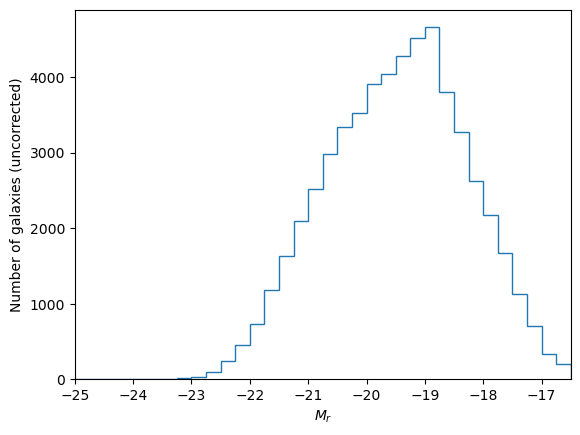

In [9]:
out = plt.hist(r,bins=np.arange(-25,-16.3,0.25),histtype='step')
plt.xlim(-25,-16.5)
plt.xlabel('$M_r$')
plt.ylabel('Number of galaxies (uncorrected)')

When you plot a histogram of galaxies by magnitude without any correction, you're essentially representing the observed distribution of galaxies in apparent magnitude space. This is similar to the situation seen in mass versus redshift plots, like in the ZFOURGE survey, where we saw that low-mass galaxies can be underrepresented. Similarly, in magnitude histograms, we may miss the low-luminosity galaxies. This happens because an object's apparent magnitude is inversely affected by its distance from the observer. The farther away a galaxy is, the dimmer it appears. As a result, the histogram is skewed towards brighter magnitudes. To correct for this distance-induced bias, we need to account for the varying distances to galaxies in our sample. This is where the 1/Vmax method comes into play.

The 1/Vmax method aims to correct these biases by accounting for the varying volumes within which galaxies can be observed. It calculates the maximum observable volume (Vmax) for each galaxy in your dataset, considering the selection limits of your survey. Then, it uses this volume as a weight to re-balance the galaxies in your histogram. In essence, it evens out the contributions of galaxies at different distances, allowing you to recover a more accurate representation of the intrinsic luminosity function. This correction is crucial for understanding the true distribution of galaxies' intrinsic properties and for making meaningful comparisons between different datasets and cosmological models.

Below, we calculate and visualise the volume of space probed by the survey as a function of absolute magnitude, taking into account magnitude limits and our redshift constraints.

64.28571428571429 -16.270572368805432


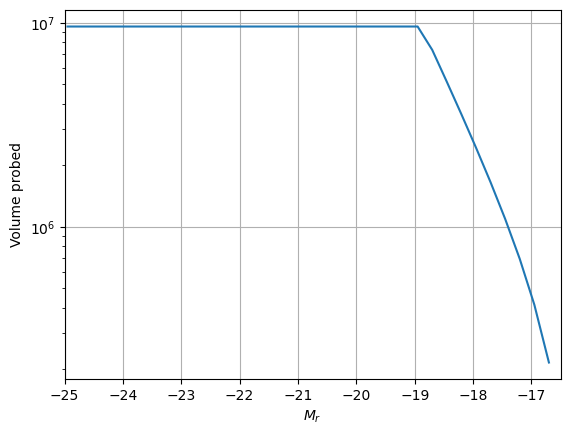

In [10]:
# center our histogram bins into mabs
mabs = out[1][0:-1] + 0.05
# apparent magnitude limit of SDSS
mlim = 17.77
# use the mlim and mabs to determine the maximum distance
dmax = 10**((mlim-mabs-25)/5)
# set a maximum distance of zmax=0.05 (based on our SQL selection criteria)
dmax[dmax>zmax*c/h0] = zmax*c/h0
# sets a minimum distance of zmin=0.015 (based on our SQL selection criteria)
dmin=.015*3.e5/70
print(dmin,mlim-5*np.log10(dmin)-25)
# volume probed as a function of mabs
vol = (dmax**3-dmin**3)

# Plot the volume probed as a function of mabs
plt.plot(mabs,vol)
plt.xlim(-25,-16.5)
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('Volume probed')
plt.grid()

Text(0, 0.5, '$\\phi$')

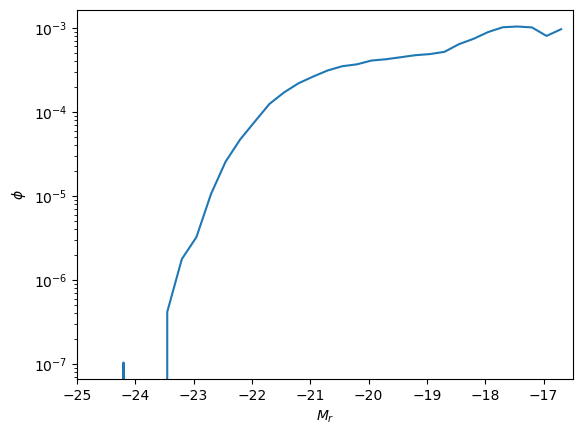

In [11]:
# corrected luminosity function
lf=out[0]/vol
plt.plot(mabs,lf)

plt.xlim(-25,-16.5)
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('$\phi$')

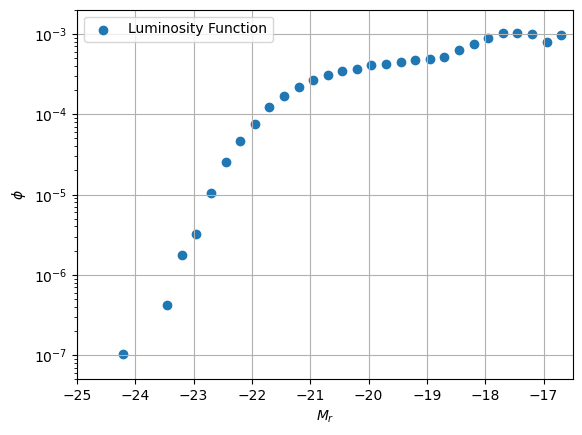

In [12]:
# create a scatter plot of the luminosity function
plt.scatter(mabs, lf, label='Luminosity Function')

plt.xlim(-25, -16.5)
plt.ylim(5e-8, 2e-3)
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('$\phi$')
plt.grid(True)
plt.legend()
plt.show()

The Schechter function gives the number of galaxies per unit magnitude (or luminosity), . Fitting a Schechter function to the corrected luminosity function is a common approach and is a mathematical model that describes the distribution of magnitudes (or luminosities) of galaxies in the universe. It consists of three parameters (the characteristic density), (the faint-end slope), and

(the characteristic magnitude). By fitting a Schechter function to the observed luminosity function, we can characterise the intrinsic properties of galaxy populations, such as their distribution of magnitudes and the presence of different galaxy types.

The fitting process involves adjusting the Schechter parameters to best match the observed data, allowing us to estimate the characteristic values that describe the magnitude distribution in the studied region of the universe. For more information, be sure to review the above recording.

We now calculate and visualise a Schechter function fit to our luminosity function represented in magnitudes.

Schechter fit:
Mstar: -21.666267 
 alpha: -1.250501 
  phistar: 0.000338


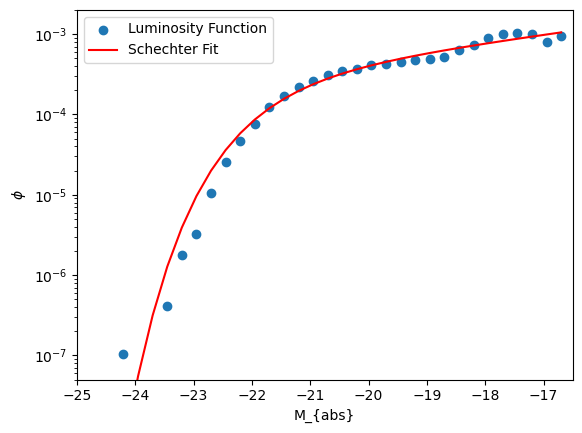

In [15]:
# Define the Schechter function
def schechter(m,mstar=-21,alpha=-1,phistar=1) :
    return phistar*10.**(-0.4*(alpha+1)*(m-mstar))*np.exp(-10.**(-0.4*(m-mstar)))

# Plot the corrected LF
plt.scatter(mabs, lf, label='Luminosity Function')
plt.xlim(-25, -16.5)
plt.ylim(5e-8, 2e-3)
plt.yscale('log')

# Do the fit with curve_fit
p0 = [-21, -1, 1]   # Starting guess for fit
from scipy.optimize import curve_fit
pars = curve_fit(schechter, mabs, lf, p0=p0)
print('Schechter fit:')
print('Mstar: {:f} \n alpha: {:f} \n  phistar: {:f}'.format(*pars[0]))

# Plot the Schechter fit
plt.plot(mabs, schechter(mabs, *pars[0]), 'r', label='Schechter Fit')
plt.xlabel('M_{abs}')
plt.ylabel('$\phi$')
plt.legend()
plt.show()